In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, auc, roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from feature_engine.creation import CyclicalFeatures
from sklearn.decomposition import PCA
from geopy.geocoders import Nominatim
from my_library import *
import re
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import utils
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## My Judge

In [2]:
def get_PR_AUC(y_true,y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    return auc(recall,precision)

algorithms = {
    'knn': KNeighborsClassifier(),
    'lr': LogisticRegression(solver = 'liblinear'),
    'dt': DecisionTreeClassifier(random_state = 42),
    'rf': RandomForestClassifier(random_state = 42),
    'gb': GradientBoostingClassifier(random_state = 42)
}

metrics = {
    'Accuracy'  : make_scorer(accuracy_score),
    'ROC_AUC'   :'roc_auc',
    'PR_AUC'    : make_scorer(get_PR_AUC),#, greater_is_better=True),
    'PRECISION' : 'precision',
    'RECALL'    : 'recall'
}

hyper_param = { 'knn': {'n_neighbors' : [2,3,4,5,6],
                        'leaf_size'   : [5,10,20,30]
                       },
                'lr' : {},
                'dt' : {'max_depth' : [2,4,6,8,10,20],
                        'criterion' : ['gini', 'entropy']
                       },
                'rf' : {'n_estimators' :[10, 20, 30, 50, 100],
                        'max_depth' : [2,4,6,8,10,20]
                       }, 
                'gb' : {'n_estimators' :[10, 20, 30, 50,100],
                        'max_depth' : [2,4,6,8,10,20]
                       }                   
}

class Judge:
    
    def __init__(self):
        self.metrics = ()
        self.params = {}
        self.hyper_param = {}
        self.innercycle = 3
        self.outercycle = 10
        return None
    
    def __str__(self):
        return f" Judging {self.nome_dataframe}"
    
    def set_research(self, refit = "ROC_AUC", grid = "Grid"):
        self.refit = refit
        self.grid  = grid
    
    def self_innercylce(self,ncycle):
        self.innercycle = ncycle
        return self
    
    def self_outercycle(self,ncycle):
        self.outercycle = ncycle
        return self
    
    def set_data(self, X, y):
        self.X = X
        self.y = y
        return self
    
    def set_algorithms(self, algorithms):
        self.algorithms = algorithms
        return self
    
    def set_params(self, params):
        self.params = params
        return self
    
    def set_metrics(self, metrics):
        self.metrics = metrics
        return self
    
    def set_hyper_param(self,algorithm):
        self.hyper_param = hyper_param[algorithm]

    def get_performance_from_algorithm(self, name, algorithm):
        cv_inner = KFold(n_splits=self.innercycle, shuffle=True, random_state=1)
        if bool(self.hyper_param):
            if self.grid.lower() == "grid":
                search = GridSearchCV(algorithm, self.hyper_param, scoring=self.metrics, n_jobs=-1, cv=cv_inner, refit=self.refit)
            else:
                search = RandomizedSearchCV(algorithm, self.hyper_param, scoring=self.metrics, n_jobs=-1, cv=cv_inner, refit=self.refit)
        else:
            search = algorithm
        cv_outer = KFold(n_splits=self.outercycle, shuffle=True, random_state=1)
        cv_results = cross_validate(search, self.X, self.y, scoring = self.metrics, cv=cv_outer,return_train_score=True,n_jobs=-1)
        risultati = []
        for i in self.metrics.keys():
            score = round(np.mean(cv_results['test_'+i]) * 100, 2)
            risultati.append(score)
        return risultati
    
    def get_comparison_table(self):
        diz = {}
        for name, algorithm in self.algorithms.items():
            self.set_hyper_param(name)
            diz[name] = self.get_performance_from_algorithm(name, algorithm)
        table = pd.DataFrame.from_dict(diz).T
        table.columns = self.metrics.keys()
        return table

## My Library

In [3]:
def ohe(data, column):
    sex_ohe = pd.get_dummies(data[column], prefix = str.lower(column))
    data.drop([column], axis = 1, inplace = True)
    data = pd.concat([data, sex_ohe], axis = 1)
    return data

def min_max_scaler(column):
    x = column.values.reshape(-1, 1) #returns a numpy array
    mms = MinMaxScaler()
    x_scaled = mms.fit_transform(x)
    return x_scaled

def replace_null_with_mean(column):
    mean_value = column.mean()
    return column.fillna(mean_value)

def replace_null_with_median(column):
    median_value = column.median()
    return column.fillna(median_value)

def replace_null_with_invalid_value(data, column_name, value = -1, suffix = "_invalid"):
    data_copy = data.copy()
    is_null = data_copy[column_name].isnull()
    data_copy[column_name] = data_copy[column_name].fillna(value)
    data_copy[column_name + suffix] = np.where(is_null, 1, 0)
    return data_copy

def replace_null_with_model_predict(estimator, data, target_name, feature_names):
    dc = data.copy()
    
    bool_target_not_null = dc[target_name].notnull()
    bool_target_is_null = dc[target_name].isnull()
    
    row_indexes_where_target_notnull = dc.index[np.where(bool_target_not_null)]
    row_indexes_where_target_isnull = dc.index[np.where(bool_target_is_null)]
    
    X_train = dc.loc[row_indexes_where_target_notnull, feature_names]
    y_train = dc.loc[row_indexes_where_target_notnull, target_name]
    X_test = dc.loc[row_indexes_where_target_isnull, feature_names]
    
    estimator.fit(X_train, y_train)
    
    preds = estimator.predict(X_test) 
    
    dc.loc[row_indexes_where_target_isnull, target_name] = preds
    
    return dc[target_name]

def transform_date(data, column_name):
    df = data.copy()
    df[column_name]           = pd.to_datetime(df[column_name], format = '%Y-%m-%d', errors = 'coerce')
    df[column_name+'_year']   = df[column_name].dt.year
    df[column_name+'_month']  = df[column_name].dt.month
    df[column_name+'_day']    = df[column_name].dt.day
    cyclical                  = CyclicalFeatures(variables=None, drop_original=True)
    X                         = cyclical.fit_transform(df[[column_name+'_month',column_name+'_day']])  
    return pd.concat([df,X],axis=1).drop([column_name+'_month',column_name+'_day',column_name], axis=1)  

def get_diz_lat_long(data,colonna,nazione):
    diz_lat_long = {}
    for i in np.unique(data[colonna]):
        geolocator = Nominatim(user_agent="http")
        city       = i
        country    = nazione
        try:
            loc        = geolocator.geocode(city+','+ country) 
#            print("city: ",city,"; latitude is :-" ,loc.latitude,"; longtitude is:-" ,loc.longitude)
            diz_lat_long[i] = [loc.latitude, loc.longitude] 
        except:
            r = re.findall('([A-Z])', city)
            splitting = city.split(r[1])
            city = splitting[0] + " " +r[1]+splitting[1]
            loc        = geolocator.geocode(city+','+ country)
#            print("city: ",city,"; latitude is :-" ,loc.latitude,"; longtitude is:-" ,loc.longitude)
            diz_lat_long[i] = [loc.latitude, loc.longitude] 
    return diz_lat_long  

def recodifica_city_latitudine(city):
    return diz_lat_long[city][0]

def recodifica_city_longitudine(city):
    return diz_lat_long[city][1]
    
def Create_numerical_category(df,columns):
    for column in columns:
        unique_feature = df[column].unique()
        for i,v in enumerate(unique_feature):
            df[column].replace(v,i,inplace=True)
    return df

def replace_with_mean(data,column_list):
    for i in column_list:
        data[i].fillna(data[i].mean(), inplace= True)
    return data

def fs_corr_matrix(X, y, n = 1):
    '''
    n (int) number of features to select
    '''
    df_num = pd.concat([y, X], axis=1)
    correlation_matrix_abs = df_num.corr().abs()
    correlation_y = correlation_matrix_abs[y.name]
    correlation_y_sorted = correlation_y.sort_values(ascending = False)
    fs = correlation_y_sorted[1:(n+1)]  # 1 to skip y itself
    return fs.index

def fs_corr_matrix_by_value(X, y, tresh = 0.1):
    '''
    tresh = threshold for the feature selection
    '''
    df_num = pd.concat([y, X], axis=1)
    correlation_matrix_abs = df_num.corr().abs()
    correlation_y = correlation_matrix_abs[y.name]
    correlation_y_sorted = correlation_y.sort_values(ascending = False)
    correlation_y_sorted = correlation_y_sorted[1:len(correlation_y_sorted)] # 1 to skip y itself
    #print(correlation_y_sorted)
    fs = correlation_y_sorted[correlation_y_sorted > tresh] 
    #fs[y.name] == False
    return fs.index

def plot_correlation_matrix(X, y):
    df_num = pd.concat([y, X], axis=1)
    fig,ax = plt.subplots(figsize=(20,10))
    correlated_matrix = df_num.corr()
    sns.heatmap(correlated_matrix, annot = True, cmap= 'Greens')
    ax.set_title('Correlation Matrix')

def fs_pca(data,tresh = 80, verbose=False):
    pca = PCA(n_components=len(data.columns), random_state=2020)
    pca.fit(data)
    X_pca = pca.transform(data)
    indici = np.where(np.cumsum(pca.explained_variance_ratio_ * 100)>tresh) 
    if verbose:
        print(print("The Explained variance is :", np.cumsum(pca.explained_variance_ratio_ * 100)))
        print("The indexes of the satisfied condition are: ",indici[0])      
    return X_pca[:,0:indici[0][1]]

## Data Loading

In [4]:
df = pd.read_csv('Dataset/weatherAUS.csv')

In [5]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
df.isnull().sum().sort_values(ascending=False)

Sunshine         69835
Evaporation      62790
Cloud3pm         59358
Cloud9am         55888
Pressure9am      15065
Pressure3pm      15028
WindDir9am       10566
WindGustDir      10326
WindGustSpeed    10263
Humidity3pm       4507
WindDir3pm        4228
Temp3pm           3609
RainTomorrow      3267
Rainfall          3261
RainToday         3261
WindSpeed3pm      3062
Humidity9am       2654
Temp9am           1767
WindSpeed9am      1767
MinTemp           1485
MaxTemp           1261
Location             0
Date                 0
dtype: int64

# Data Pre-Processing

In [7]:
# delete the rows where the target column is missing
df = df[df['RainTomorrow'].notnull()]

In [8]:
df['RainToday'].replace(["No","Yes"],[0,1],inplace=True)
df['RainTomorrow'].replace(["No","Yes"],[0,1],inplace=True)

## Transforming Date Time

In [9]:
df = transform_date(df, 'Date')

In [10]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_year,Date_month_sin,Date_month_cos,Date_day_sin,Date_day_cos
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,NaN,16.9,21.8,0.0,0,2008,-2.449294e-16,1.0,0.201299,0.979530
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,NaN,17.2,24.3,0.0,0,2008,-2.449294e-16,1.0,0.394356,0.918958
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,2.0,21.0,23.2,0.0,0,2008,-2.449294e-16,1.0,0.571268,0.820763
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,NaN,18.1,26.5,0.0,0,2008,-2.449294e-16,1.0,0.724793,0.688967
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,8.0,17.8,29.7,0.0,0,2008,-2.449294e-16,1.0,0.848644,0.528964


## Transforming Location

In [11]:
diz_lat_long = get_diz_lat_long(df,"Location","Australia")

In [12]:
df['Latitudine'] = df['Location'].apply(recodifica_city_latitudine)
df['Longitudine'] = df['Location'].apply(recodifica_city_longitudine)
df.drop('Location', axis = 1, inplace = True)

In [13]:
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Temp3pm,RainToday,RainTomorrow,Date_year,Date_month_sin,Date_month_cos,Date_day_sin,Date_day_cos,Latitudine,Longitudine
0,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,...,21.8,0.0,0,2008,-2.449294e-16,1.0,0.201299,0.979530,-36.080477,146.91628
1,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,...,24.3,0.0,0,2008,-2.449294e-16,1.0,0.394356,0.918958,-36.080477,146.91628
2,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,...,23.2,0.0,0,2008,-2.449294e-16,1.0,0.571268,0.820763,-36.080477,146.91628
3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,...,26.5,0.0,0,2008,-2.449294e-16,1.0,0.724793,0.688967,-36.080477,146.91628
4,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,...,29.7,0.0,0,2008,-2.449294e-16,1.0,0.848644,0.528964,-36.080477,146.91628


## Substituing NaN Values

In [14]:
df['RainToday'] = replace_null_with_model_predict(DecisionTreeClassifier(), df, 'RainToday', ['RainTomorrow', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine'])

In [15]:
df = replace_with_mean(df,['MinTemp','MaxTemp', 'Temp9am', 'Temp3pm'])

In [16]:
df['Rainfall'] = replace_null_with_model_predict(DecisionTreeRegressor(max_depth=5), df, 'Rainfall', ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine'])

In [17]:
df['WindGustDir'] = replace_null_with_model_predict(DecisionTreeClassifier(max_depth=5), df, 'WindGustDir', ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday'])

In [18]:
df['WindDir9am'] = replace_null_with_model_predict(DecisionTreeClassifier(max_depth=5), df, 'WindDir9am', ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday'])
df['WindDir3pm'] = replace_null_with_model_predict(DecisionTreeClassifier(max_depth=5), df, 'WindDir3pm', ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday'])

In [19]:
df = Create_numerical_category(df,['WindGustDir', 'WindDir9am', 'WindDir3pm']) 

In [20]:
df['WindSpeed9am'] = replace_null_with_model_predict(DecisionTreeRegressor(max_depth=5), df, 'WindSpeed9am', ['WindGustDir', 'WindDir9am', 'WindDir3pm','MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday'])
df['WindSpeed3pm'] = replace_null_with_model_predict(DecisionTreeRegressor(max_depth=5), df, 'WindSpeed3pm', ['WindGustDir', 'WindDir9am', 'WindDir3pm','MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday'])
df['Humidity9am']  = replace_null_with_model_predict(DecisionTreeRegressor(max_depth=5), df, 'Humidity9am',  ['WindGustDir', 'WindDir9am', 'WindDir3pm','MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday'])
df['Humidity3pm']  = replace_null_with_model_predict(DecisionTreeRegressor(max_depth=5), df, 'Humidity3pm',  ['WindGustDir', 'WindDir9am', 'WindDir3pm','MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday'])
df['Pressure9am']  = replace_null_with_model_predict(DecisionTreeRegressor(max_depth=5), df, 'Pressure9am',  ['WindGustDir', 'WindDir9am', 'WindDir3pm','MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday'])
df['Pressure3pm']  = replace_null_with_model_predict(DecisionTreeRegressor(max_depth=5), df, 'Pressure3pm',  ['WindGustDir', 'WindDir9am', 'WindDir3pm','MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday'])

In [21]:
df['WindGustSpeed'] = replace_null_with_model_predict(DecisionTreeRegressor(max_depth=5), df, 'WindGustSpeed', ['WindGustDir', 'WindDir9am', 'WindDir3pm','MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday'])

In [22]:
df['Cloud9am'] = replace_null_with_model_predict(DecisionTreeRegressor(max_depth=5), df, 'Cloud9am', ['WindGustDir', 'WindDir9am', 'WindDir3pm','MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday', 'WindSpeed9am', 'Humidity9am', 'Pressure9am'])
df['Cloud3pm'] = replace_null_with_model_predict(DecisionTreeRegressor(max_depth=5), df, 'Cloud3pm', ['WindGustDir', 'WindDir9am', 'WindDir3pm','MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday', 'WindSpeed3pm', 'Humidity3pm', 'Pressure3pm'])

In [23]:
df['Evaporation'] = replace_null_with_model_predict(DecisionTreeRegressor(max_depth=5), df, 'Evaporation', ['WindGustDir', 'WindDir9am', 'WindDir3pm','MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday', 'WindSpeed9am', 'Humidity9am', 'Pressure9am', 'WindSpeed3pm', 'Humidity3pm', 'Pressure3pm'])
df['Sunshine'] = replace_null_with_model_predict(DecisionTreeRegressor(max_depth=5), df, 'Sunshine', ['WindGustDir', 'WindDir9am', 'WindDir3pm','MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Date_month_sin', 'Date_month_cos', 'Date_day_sin', 'Date_day_sin', 'Latitudine', 'Longitudine', 'RainTomorrow', 'RainToday', 'WindSpeed9am', 'Humidity9am', 'Pressure9am', 'WindSpeed3pm', 'Humidity3pm', 'Pressure3pm'])

In [24]:
df.isnull().sum().sort_values(ascending=False)

MinTemp           0
MaxTemp           0
Latitudine        0
Date_day_cos      0
Date_day_sin      0
Date_month_cos    0
Date_month_sin    0
Date_year         0
RainTomorrow      0
RainToday         0
Temp3pm           0
Temp9am           0
Cloud3pm          0
Cloud9am          0
Pressure3pm       0
Pressure9am       0
Humidity3pm       0
Humidity9am       0
WindSpeed3pm      0
WindSpeed9am      0
WindDir3pm        0
WindDir9am        0
WindGustSpeed     0
WindGustDir       0
Sunshine          0
Evaporation       0
Rainfall          0
Longitudine       0
dtype: int64

## Create Categorical Variable

In [25]:
df = ohe(df, "WindGustDir")
df = ohe(df, "WindDir9am")
df = ohe(df, "WindDir3pm")

In [26]:
df.head(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,winddir3pm_6,winddir3pm_7,winddir3pm_8,winddir3pm_9,winddir3pm_10,winddir3pm_11,winddir3pm_12,winddir3pm_13,winddir3pm_14,winddir3pm_15
0,13.4,22.9,0.6,6.293585,9.829391,44.0,20.0,24.0,71.0,22.0,...,0,0,0,0,0,0,0,0,0,0
1,7.4,25.1,0.0,6.471350,11.290517,44.0,4.0,22.0,44.0,25.0,...,0,0,0,0,0,0,0,0,0,0
2,12.9,25.7,0.0,10.208907,11.290517,46.0,19.0,26.0,38.0,30.0,...,0,0,0,0,0,0,0,0,0,0
3,9.2,28.0,0.0,8.143203,11.290517,24.0,11.0,9.0,45.0,16.0,...,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,5.975649,11.290517,41.0,7.0,20.0,82.0,33.0,...,0,0,0,0,0,0,0,0,0,0


## Standardize the dataframe

In [27]:
y        = df['RainTomorrow']
X        = df.drop('RainTomorrow', axis = 1)
#scaler   = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#X        = pd.DataFrame(X_scaled, columns=X.columns)
X = (X - X.mean()) / X.std()
X.head(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,winddir3pm_6,winddir3pm_7,winddir3pm_8,winddir3pm_9,winddir3pm_10,winddir3pm_11,winddir3pm_12,winddir3pm_13,winddir3pm_14,winddir3pm_15
0,0.189954,-0.045964,-0.207834,0.278600,0.699525,0.302932,0.678454,0.613591,0.112105,-1.427434,...,-0.25074,-0.239684,-0.24083,-0.246257,-0.276545,-0.300462,-0.254771,-0.27415,-0.217875,-0.250248
1,-0.749172,0.263479,-0.279040,0.327492,1.129058,0.302932,-1.127866,0.384563,-1.310723,-1.282277,...,-0.25074,-0.239684,-0.24083,-0.246257,-0.276545,-0.300462,-0.254771,-0.27415,-0.217875,-0.250248
2,0.111693,0.347872,-0.279040,1.355466,1.129058,0.454481,0.565559,0.842618,-1.626907,-1.040348,...,-0.25074,-0.239684,-0.24083,-0.246257,-0.276545,-0.300462,-0.254771,-0.27415,-0.217875,-0.250248
3,-0.467434,0.671380,-0.279040,0.787317,1.129058,-1.212558,-0.337601,-1.104118,-1.258025,-1.717749,...,-0.25074,-0.239684,-0.24083,-0.246257,-0.276545,-0.300462,-0.254771,-0.27415,-0.217875,-0.250248
4,0.831689,1.276200,-0.160363,0.191155,1.129058,0.075608,-0.789181,0.155535,0.691775,-0.895191,...,-0.25074,-0.239684,-0.24083,-0.246257,-0.276545,-0.300462,-0.254771,-0.27415,-0.217875,-0.250248


## Feature Selection

## Corr Matrix

In [28]:
#y_standard = (y - y.mean()) / y.std()
#plot_correlation_matrix(X, y)

In [29]:
X_fs_corr_by_value = X[fs_corr_matrix_by_value(X, y, 0.2)]
print("After the feature Selection by means corr_matrix we have n = %4d features" % (len(X_fs_corr_by_value.columns)))

After the feature Selection by means corr_matrix we have n =   10 features


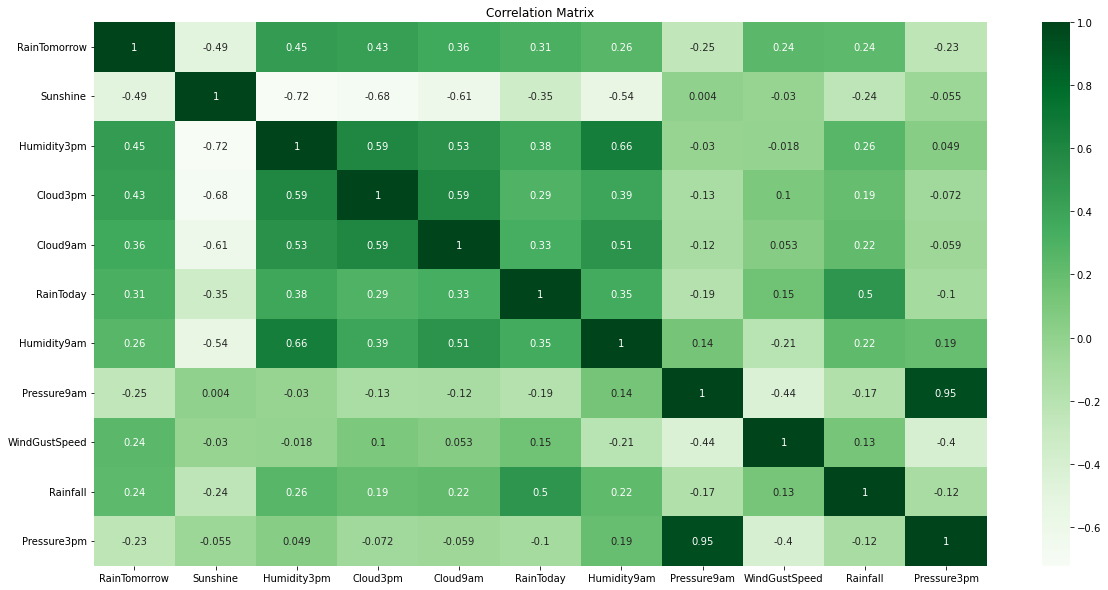

In [30]:
plot_correlation_matrix(X_fs_corr_by_value, y)

## PCA

In [31]:
X_corr_pca = fs_pca(X_fs_corr_by_value, 90)

In [32]:
print("After the feature Selection by means corr_matrix and PCA we have n = %4d features" % (X_corr_pca.shape[1]))

After the feature Selection by means corr_matrix and PCA we have n =    7 features


## Balancing the Dataset

In [33]:
y.value_counts()

0    110316
1     31877
Name: RainTomorrow, dtype: int64

In [34]:
y_values = y.values

In [35]:
# SMOTE (need all numerical values)
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_corr_pca, y_values)
print(X_smote.shape)
print(y_smote.shape)

(220632, 7)
(220632,)


In [36]:
# Oversampling
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_corr_pca, y_values)
print(X_over.shape)
print(y_over.shape)

(220632, 7)
(220632,)


In [37]:
# Undersampling
ros = RandomUnderSampler(random_state=42)
X_under, y_under = ros.fit_resample(X_corr_pca, y_values)
print(X_under.shape)
print(y_under.shape)

(63754, 7)
(63754,)


In [38]:
#X_res = X_res[0:5000]
#y_res = y_res[0:5000]

## Judging the model

In [39]:
judge_under = Judge()
judge_under.set_data(X_under, y_under).set_algorithms(algorithms).set_metrics(metrics).set_research("ROC_AUC", "Random")

In [40]:
%%time
print(f"In this case the REFIT is : '{judge_under.refit}' while the ParameterSearch is : '{judge_under.grid}' ")
judge_under.get_comparison_table()

In this case the REFIT is : 'ROC_AUC' while the ParameterSearch is : 'Random' 
CPU times: user 102 ms, sys: 123 ms, total: 225 ms
Wall time: 11min


,Accuracy,ROC_AUC,PR_AUC,PRECISION,RECALL
knn,80.49,87.90,85.60,82.52,77.36
lr,79.80,88.22,84.85,79.76,79.86
dt,80.16,88.08,85.04,78.94,82.30
rf,81.83,89.88,86.27,80.76,83.56
gb,81.64,89.74,86.12,80.43,83.62


In [41]:
judge_over = Judge()
judge_over.set_data(X_over, y_over).set_algorithms(algorithms).set_metrics(metrics).set_research("ROC_AUC", "Random")

In [42]:
%%time
print(f"In this case the REFIT is : '{judge_over.refit}' while the ParameterSearch is : '{judge_over.grid}' ")
judge_over.get_comparison_table()

In this case the REFIT is : 'ROC_AUC' while the ParameterSearch is : 'Random' 
CPU times: user 185 ms, sys: 193 ms, total: 378 ms
Wall time: 40min 34s


,Accuracy,ROC_AUC,PR_AUC,PRECISION,RECALL
knn,85.13,92.35,88.64,83.42,87.71
lr,79.94,88.30,84.96,79.94,79.95
dt,89.50,92.55,91.55,85.71,94.78
rf,93.00,98.43,94.08,89.31,97.71
gb,92.60,97.71,93.83,89.20,96.93


In [43]:
judge_smote = Judge()
judge_smote.set_data(X_smote, y_smote).set_algorithms(algorithms).set_metrics(metrics).set_research("ROC_AUC", "Random")

In [44]:
%%time
print(f"In this case the REFIT is : '{judge_smote.refit}' while the ParameterSearch is : '{judge_smote.grid}' ")
judge_smote.get_comparison_table()

In this case the REFIT is : 'ROC_AUC' while the ParameterSearch is : 'Random' 
CPU times: user 186 ms, sys: 152 ms, total: 338 ms
Wall time: 41min 58s


,Accuracy,ROC_AUC,PR_AUC,PRECISION,RECALL
knn,88.06,94.34,90.56,84.40,93.43
lr,80.10,88.46,85.07,80.05,80.19
dt,81.74,89.60,86.16,80.07,84.53
rf,87.40,94.34,90.24,85.39,90.21
gb,88.19,94.93,90.81,86.04,91.17


## Domande

1. La standardizzazione conviene farla prima o dopo la corr ? Perché comunque va fatta prima della PCA
2. Per un dataset non-bilanciato, il modello di rilascio si ri-fitta sul campione "non-bilanciato" o quello "bilanciato" ?
3. Se la distribuzione di una variabile categorica non è guassiana che come la si può rendere "più" guassiana?